<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Homework_3_point_cloud_mnist_Nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tables --upgrade

     |████████████████████████████████| 4.3MB 3.5MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
import glob
from tqdm.notebook import tqdm
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!wget -O  Data.zip https://www.dropbox.com/sh/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a?dl=0

--2020-06-23 14:40:45--  https://www.dropbox.com/sh/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a [following]
--2020-06-23 14:40:45--  https://www.dropbox.com/sh/raw/h7wj4owo5vxwzgp/AACdZ5vjsHRv6utQk0_ZtIH4a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucedbdb72ebd0f1c8c26bdb97b54.dl.dropboxusercontent.com/zip_download_get/AdnmTmikeo4VP9FamK9CzLBz-RLaf03Vs1qcNrzjdYgCEf_z6fT90Go31hRPh2XM80kHhLxnKAic_8FKlfx9jPxBQk6S3CpGci971dcaZ79mjQ [following]
--2020-06-23 14:40:46--  https://ucedbdb72ebd0f1c8c26bdb97b54.dl.dropboxusercontent.com/zip_download_get/AdnmTmikeo4VP9FamK9CzLBz-RLaf03Vs1qcNrzjdYgCEf_z6fT90Go31hRPh2XM80kHhLxnKAic_8FKlfx9

In [4]:
!unzip /content/Data.zip -d /content/Data

Archive:  /content/Data.zip
mapname:  conversion of  failed
 extracting: /content/Data/valid_ds.h5  
 extracting: /content/Data/training_ds.h5  


In [5]:
a = pd.read_hdf('/content/Data/training_ds.h5')

# Homework 3
## Point Cloud MNIST with DeepSet


below you have a custom dataloader for the point-cloud MNIST dataset,

the training and validation datasets are linked from the course website

In [6]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        
        self.df = pd.read_hdf(path)
        
        self.label = torch.LongTensor(self.df.label)
        
        self.n_points = self.df.n_points
        
        
    def __len__(self):
       
        return len(self.label)


    def __getitem__(self, idx):
        
    
        return torch.FloatTensor(self.df.iloc[idx].xy), self.label[idx]

In [7]:
ds = CustomDataset('/content/Data/training_ds.h5')

#### the data is exactly like the MNIST dataset, except that instead of a 28x28 image,
#### you get a (N x 2) array of points (different number of points for each item in the dataset) 

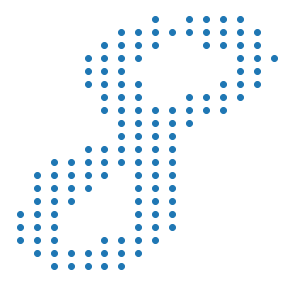

In [8]:
fig,ax = plt.subplots(figsize=(5,5))

xy = ds[445][0]

ax.scatter( xy[:,0],xy[:,1] )

ax.set_axis_off()

plt.show()

### the dataset object has a n_points variable that tells us how many points in each item

In [9]:
ds.n_points

0       117
1       130
2        88
3        70
4        97
       ... 
9995    120
9996    111
9997    114
9998     81
9999     88
Name: n_points, Length: 10000, dtype: object

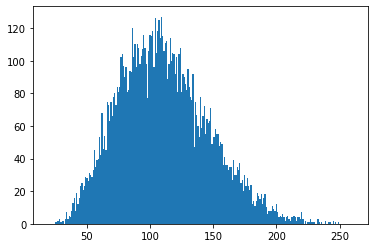

In [10]:
plt.hist(ds.n_points,np.linspace(19.5,260.5,242))
plt.show()

## One way to deal with this variable size is to use a custom Batch Sampler

https://pytorch.org/docs/stable/data.html

This object will tell our dataloader which item indices to request for the batches - 
and we can "rig" it to return batches where all the items have the same N, and therefore we can stack them without a custom colate function

In [11]:
class CustomBatchSampler(Sampler):
    def __init__(self, points_per_entry, batch_size):
        
        self.batch_size = batch_size
        self.N_per_entry = points_per_entry
        self.batches = {}
        
    def generate_batches(self):
        
        self.entries_with_N = {}
        running_idx = -1

        for N in set(self.N_per_entry):
            
            self.entries_with_N[N] = np.where(self.N_per_entry == N)[0]

            how_many = len(self.entries_with_N[N])
            n_batches = np.amax([ how_many / self.batch_size, 1])

            self.entries_with_N[N] = np.array_split(np.random.permutation(self.entries_with_N[N]),
                                                           n_batches)
            for batch in self.entries_with_N[N]:
                running_idx += 1
                self.batches[running_idx] = batch

        self.n_batches = running_idx + 1

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        
        self.generate_batches()
        
        batch_order = np.random.permutation(np.arange(self.n_batches))
        for i in batch_order:
            yield self.batches[i]

In [12]:
batch_size = 120
batch_sampler = CustomBatchSampler(ds.n_points, batch_size)
train_data_loader = DataLoader(ds, batch_sampler=batch_sampler)

In [13]:
for epoch in range(3):
    for x,y in train_data_loader:
        print(x.shape)
        print(x.size(0))
        print(y.shape)
    break

torch.Size([1, 249, 2])
1
torch.Size([1])
torch.Size([1, 225, 2])
1
torch.Size([1])
torch.Size([49, 157, 2])
49
torch.Size([49])
torch.Size([62, 146, 2])
62
torch.Size([62])
torch.Size([1, 228, 2])
1
torch.Size([1])
torch.Size([59, 141, 2])
59
torch.Size([59])
torch.Size([4, 212, 2])
4
torch.Size([4])
torch.Size([21, 179, 2])
21
torch.Size([21])
torch.Size([53, 151, 2])
53
torch.Size([53])
torch.Size([75, 69, 2])
75
torch.Size([75])
torch.Size([4, 208, 2])
4
torch.Size([4])
torch.Size([8, 194, 2])
8
torch.Size([8])
torch.Size([31, 52, 2])
31
torch.Size([31])
torch.Size([35, 163, 2])
35
torch.Size([35])
torch.Size([73, 73, 2])
73
torch.Size([73])
torch.Size([127, 109, 2])
127
torch.Size([127])
torch.Size([21, 47, 2])
21
torch.Size([21])
torch.Size([19, 42, 2])
19
torch.Size([19])
torch.Size([10, 192, 2])
10
torch.Size([10])
torch.Size([118, 102, 2])
118
torch.Size([118])
torch.Size([8, 199, 2])
8
torch.Size([8])
torch.Size([98, 92, 2])
98
torch.Size([98])
torch.Size([3, 219, 2])
3
torch

## Building a DeepSet model

you only have three components - a fully connected network that creates the node embedding, a sum operation, and a classifier

In [14]:
# the linear layer operates on the last dimension:

linear_layer = nn.Linear(10,5)

linear_layer(  torch.rand((345,10)) ).shape, linear_layer(  torch.rand((345,76,10)) ).shape

(torch.Size([345, 5]), torch.Size([345, 76, 5]))

In [15]:
# for the the mean operation you need to specify the dimension:

x = torch.rand((42,15,10))

torch.mean(x,dim=1).shape

torch.Size([42, 10])

## build the model, train, submit when you reach above 75% accuracy on the validation set:

In [16]:
class DeepSet(nn.Module):
    def __init__(self):
        super(DeepSet, self).__init__()
        self.embedding1 = nn.Linear(2,16)
        #self.embedding2 = nn.Linear(16,64)
        self.embedding3 = nn.Linear(64,512)
        self.linear1 = nn.Linear(512,32)
        self.linear2 = nn.Linear(32,10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.embedding1(x))
        x = F.relu(self.embedding2(x))
        x = F.relu(self.embedding3(x))
        x = torch.mean(x,1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [17]:
net = DeepSet()

In [18]:
import torch.cuda
if torch.cuda.is_available():
    net.cuda()

In [19]:
loss_func = nn.CrossEntropyLoss()

In [20]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

from tqdm.notebook import tqdm

In [21]:
def compute_accuracy(data_loader,net):
    
    net.eval()
    
    total_number = 0
    total_correct = 0
    
    for x,y in data_loader:
        if torch.cuda.is_available():
          x,y = x.cuda(),y.cuda()
        
        prediction = net(x).cpu().data.numpy()
        prediction = np.argmax(prediction,axis=1)
        y = y.cpu().data.numpy()
        #print(y.shape)
        #print(prediction.shape)
        correct = len( np.where(prediction==y)[0] )
        
        total_correct+=correct
        total_number+=x.shape[0]
        
    return total_correct/float(total_number)

In [22]:
test_ds = CustomDataset('/content/Data/valid_ds.h5')
batch_size = 120
batch_sampler_test_ds = CustomBatchSampler(test_ds.n_points, batch_size)
data_loader_test = DataLoader(test_ds, batch_sampler=batch_sampler_test_ds)

compute_accuracy(data_loader_test,net)

0.1009

In [23]:
from tqdm.notebook import tqdm

n_epochs = 25


loss_vs_epoch = []
accuracy_vs_epoch = []
for epoch in tqdm(range(n_epochs)):
  training_loss = 0
  validation_loss =0
  training_accuracy = 0
  validation_accuracy = 0
  net.train()
  for x,y in train_data_loader:
      if torch.cuda.is_available():
        x,y = x.cuda(),y.cuda()
      #clear the grade of all optimzed variables 
      optimizer.zero_grad()
      output = net(x)
      #print(y)
      #print(output)
      #calculate the loss 
      loss = loss_func(output,y)
      loss.backward()
      optimizer.step()
      training_loss += loss.item() * x.size(0)

  net.eval()
  for x,y in data_loader_test:
      if torch.cuda.is_available():
        x,y = x.cuda(),y.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = net(x)   # calculate the loss
      loss = loss_func(output,y) # update running validation loss 
      validation_loss += loss.item() * x.size(0)
      
  training_accuracy = compute_accuracy(train_data_loader,net)
  validation_accuracy = compute_accuracy(data_loader_test,net)
  loss_vs_epoch.append([training_loss/len(ds), validation_loss/len(test_ds)])
  accuracy_vs_epoch.append([training_accuracy,validation_accuracy])


tensor(2.2806, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4632, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2723, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3941, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3389, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3242, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3552, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3208, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2954, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2590, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3320, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3878, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.4581, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2798, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.3783, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2837, device='cuda:0', grad_fn=<NllLossBackward

KeyboardInterrupt: ignored

In [ ]:
loss_vs_epoch = np.array(loss_vs_epoch)

plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

In [ ]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()

In [ ]:
torch.save(net.state_dict(), '/content/model.pt')